# Movie Analysis

>Business Problem: Microsoft wants to make a movie company and would like to know what will be most profitable in their debut

# Packages Used

>Below are the packages that are to be used in this data analysis to help with data access, analysis, cleaning and presentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlalchemy import create_engine

# Load Data

>Load the data that will be used in this analysis, namely the data from imdb.title.basics, imdb.basics.ratings, and bom.movie_gross.

In [2]:
gross_df= pd.read_csv('data/bom.movie_gross.csv.gz')
imdb_basics_df= pd.read_csv('data/imdb.title.basics.csv.gz')
imdb_rating_df= pd.read_csv('data/imdb.title.ratings.csv.gz')
movie_budgets_df= pd.read_csv('data/tn.movie_budgets.csv.gz')
rt_movie_info_df = pd.read_csv('data/rt.movie_info.tsv.gz', sep='\t')

# Initial Quick Assessment

> Using .info() on the datasets in order to determine the datatypes in each of the columns. This will help inform any changes that will need to be done in order to facilitate cleaning and analysis of the data.

In [3]:
#Dtype of foreign_gross will need to be changed to work with analysis plan
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
#NaN items might be something we will potentially have to remove.
imdb_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [5]:
#Merging tconst of this dataset will be useful with tconst of imdb_basics_df.
imdb_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [6]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
rt_movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


# Functions in Use


### Column Function 

This function helps facilitate data cleaning by removing non-numeric characters that will cause issues in data analysis.

In [8]:
# $ , and minutes will cause errors when running data
def column_adjust(column, df):
    df[column] = df[column].str.replace('$','')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].str.replace(' minutes','')
    df[column] = df[column].apply(pd.to_numeric)
    return df[column]

### Duplicate and NaN Function 

This function will help detect any extraneous factors that will cause our data to run errors when analyzing.

In [9]:
#This function helps simplify several measures all at once instead of having to run th
def extra_stuff(df):
    print('Sum of NaN values:', df.isna().sum())
    print('Duplicate Rows:', df[df.duplicated()])
    print('DataFrame Info:', df.describe())
    return df

### DataFrame Function  

This function will help create DataFrames at a later date as we continue to work on our data

In [10]:
def dataframe_creator():
    """Returns dataframe from SQL Query"""
    df= pd.DataFrame(cur.fetchall())
    df.columns= [x[0] for x in cur.description]
    return df

### Table Function 
 

This function helps create tables based on DataFrames being used.

In [11]:
def data_table(df, table_name):
    """Writes to SQL database tables from dataframes."""
    df.to_sql(table_name, con=engine)
    engine.execute("""SELECT * from {}""".format(table_name)).fetchall()

# Data Cleaning

### BOM Data

In [12]:
gross_df['foreign_gross']= column_adjust('foreign_gross', gross_df)

extra_stuff(gross_df)

Sum of NaN values: title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64
Duplicate Rows: Empty DataFrame
Columns: [title, studio, domestic_gross, foreign_gross, year]
Index: []
DataFrame Info:        domestic_gross  foreign_gross         year
count    3.359000e+03   2.037000e+03  3387.000000
mean     2.874585e+07   7.487281e+07  2013.958075
std      6.698250e+07   1.374106e+08     2.478141
min      1.000000e+02   6.000000e+02  2010.000000
25%      1.200000e+05   3.700000e+06  2012.000000
50%      1.400000e+06   1.870000e+07  2014.000000
75%      2.790000e+07   7.490000e+07  2016.000000
max      9.367000e+08   9.605000e+08  2018.000000


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [13]:
#removing the NaN values in the domestic gross and foreign gross columns
gross_df.dropna(subset=['domestic_gross'], inplace=True)

gross_df.dropna(subset=['foreign_gross'], inplace=True)

gross_df.isna().sum()

title             0
studio            2
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

The gross_df.isna().sum() value tells us that the number of NaN's in both domestic and foreign gross have been removed. This will help in limited obfuscated data that could make inference and plotting difficult in the future. We will do a quick check of our data below to see how many values are left to work with.

In [14]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2009 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2009 non-null   float64
 3   foreign_gross   2009 non-null   float64
 4   year            2009 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 94.2+ KB


### IMDB Title Basics Data 

In [15]:
# extra_stuff(imdb_basics_df)
imdb_basics_df.head()
imdb_basics_df.set_index('tconst')

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...
tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy


### IMDB Rating Basics Data 


In [16]:
extra_stuff(imdb_rating_df)
imdb_rating_df.head()
imdb_rating_df.set_index('tconst')

Sum of NaN values: tconst           0
averagerating    0
numvotes         0
dtype: int64
Duplicate Rows: Empty DataFrame
Columns: [tconst, averagerating, numvotes]
Index: []
DataFrame Info:        averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06


,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


In [17]:
imdb_basics_df= pd.merge( imdb_basics_df, imdb_rating_df, on= 'tconst')
imdb_basics_df.set_index('tconst')
extra_stuff(imdb_basics_df)

Sum of NaN values: tconst                0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64
Duplicate Rows: Empty DataFrame
Columns: [tconst, primary_title, original_title, start_year, runtime_minutes, genres, averagerating, numvotes]
Index: []
DataFrame Info:          start_year  runtime_minutes  averagerating      numvotes
count  73856.000000     66236.000000   73856.000000  7.385600e+04
mean    2014.276132        94.654040       6.332729  3.523662e+03
std        2.614807       208.574111       1.474978  3.029402e+04
min     2010.000000         3.000000       1.000000  5.000000e+00
25%     2012.000000        81.000000       5.500000  1.400000e+01
50%     2014.000000        91.000000       6.500000  4.900000e+01
75%     2016.000000       104.000000       7.400000  2.820000e+02
max     2019.000000     51420.000000      10.000000  1.841066e+06


,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,NaN,6.6,5


### TN Movie Budget Data

In [18]:
movie_budgets_df['production_budget'] = column_adjust('production_budget', movie_budgets_df)
movie_budgets_df['domestic_gross'] = column_adjust('domestic_gross', movie_budgets_df)
movie_budgets_df['worldwide_gross'] = column_adjust('worldwide_gross', movie_budgets_df)
extra_stuff(movie_budgets_df)

Sum of NaN values: id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64
Duplicate Rows: Empty DataFrame
Columns: [id, release_date, movie, production_budget, domestic_gross, worldwide_gross]
Index: []
DataFrame Info:                 id  production_budget  domestic_gross  worldwide_gross
count  5782.000000       5.782000e+03    5.782000e+03     5.782000e+03
mean     50.372363       3.158776e+07    4.187333e+07     9.148746e+07
std      28.821076       4.181208e+07    6.824060e+07     1.747200e+08
min       1.000000       1.100000e+03    0.000000e+00     0.000000e+00
25%      25.000000       5.000000e+06    1.429534e+06     4.125415e+06
50%      50.000000       1.700000e+07    1.722594e+07     2.798445e+07
75%      75.000000       4.000000e+07    5.234866e+07     9.764584e+07
max     100.000000       4.250000e+08    9.366622e+08     2.776345e+09


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0
5778,79,"Apr 2, 1999",Following,6000,48482,240495
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0


### Rotten Tomatoes Movie Data

In [19]:
rt_movie_info_df.info()
rt_movie_info_df['box_office'] = column_adjust('box_office',rt_movie_info_df)
rt_movie_info_df['runtime'] = column_adjust('runtime',rt_movie_info_df)
rt_movie_info_df.drop(columns='id', inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [20]:
extra_stuff(rt_movie_info_df)

Sum of NaN values: synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64
Duplicate Rows:                                                synopsis rating  \
131                                                 NaN    NaN   
923                                                 NaN     NR   
1362  A group of air crash survivors are stranded in...  PG-13   
1543                                                NaN    NaN   

                           genre director                    writer  \
131                          NaN      NaN                       NaN   
923                        Drama      NaN                       NaN   
1362  Action and Adventure|Drama      NaN  Edward Burns|Scott Frank   
1543                         NaN      NaN                       NaN   

      theater_date     dvd_date cu

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1555,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106.0,New Line Cinema
1556,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88.0,Paramount Vantage
1557,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111.0,NaN
1558,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101.0,NaN


In [21]:
rt_movie_info_df.drop_duplicates(keep='first',inplace=True)
extra_stuff(rt_movie_info_df)

Sum of NaN values: synopsis          59
rating             1
genre              6
director         195
writer           446
theater_date     356
dvd_date         356
currency        1217
box_office      1217
runtime           27
studio          1063
dtype: int64
Duplicate Rows: Empty DataFrame
Columns: [synopsis, rating, genre, director, writer, theater_date, dvd_date, currency, box_office, runtime, studio]
Index: []
DataFrame Info:          box_office      runtime
count  3.390000e+02  1529.000000
mean   3.795617e+07   103.962721
std    5.756912e+07    24.649598
min    3.630000e+02     5.000000
25%    1.870101e+06    91.000000
50%    1.403796e+07   100.000000
75%    4.498339e+07   114.000000
max    3.680000e+08   358.000000


,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1555,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106.0,New Line Cinema
1556,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88.0,Paramount Vantage
1557,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111.0,NaN
1558,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101.0,NaN


# Database Creation

In this section we will create the databases necessary to begin to work on finally manipulating and creating visualizations with our cleaned data.

In [22]:
conn = sqlite3.connect('movies.sqlite')
cur = conn.cursor()
engine = create_engine('sqlite:///movies.sqlite', echo=False)

In [23]:
data_table(rt_movie_info_df,'RTMovie')

In [24]:
data_table(imdb_basics_df,'imdb_basics_df')

In [25]:
data_table(movie_budgets_df,'TN_movie_budgets')

# Visualizations

In this section we create the visualizations using Seaboard that will help inform our presentation to Microsoft

In [26]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

sns.set_palette(sns.cubehelix_palette(8))
sns.set_context("talk")
sns.set(rc={'figure.figsize':(10,8)})

[]

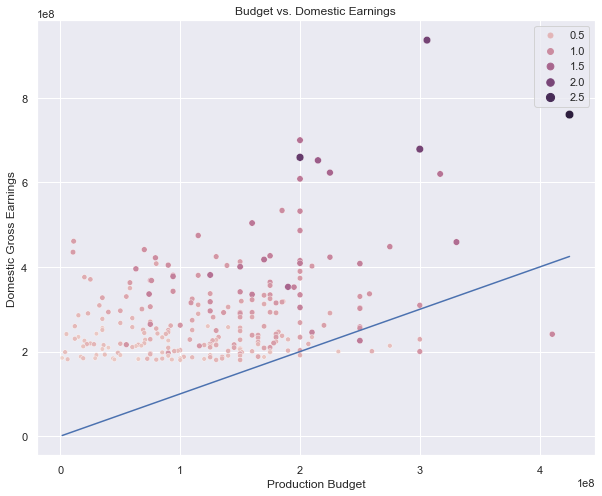

In [28]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TN_movie_budgets
               ORDER BY domestic_gross DESC
               LIMIT 250;""")
financial_df = dataframe_creator()
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    size=financial_df['worldwide_gross'],
    hue=financial_df['worldwide_gross']
    )

# Create line for reference to production_budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot)
             

financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

/Users/andres/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Movies by Production Values')

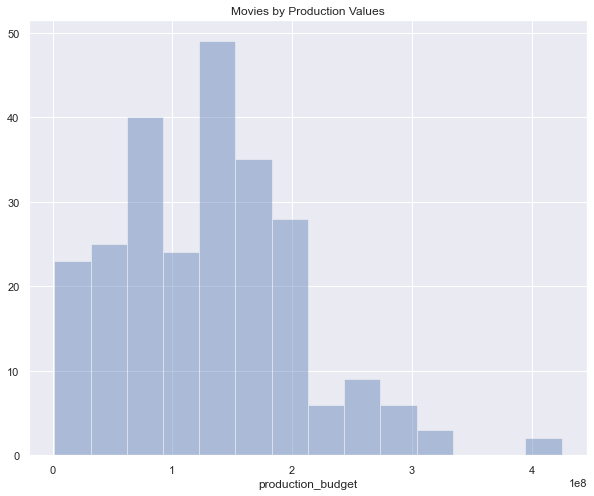

In [30]:
financial_plot = sns.distplot(financial_df['production_budget'], kde=False)
financial_plot.set_title("Movies by Production Values")

In [32]:
df2=pd.read_csv('data/imdb.title.basics.csv.gz')
df2.info()


df2.drop(['runtime_minutes'], axis= 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


,tconst,primary_title,original_title,start_year,genres
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"
...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,NaN


                                          movie  production_budget  \
0          Star Wars Ep. VII: The Force Awakens          306000000   
1                                        Avatar          425000000   
2                        Avengers: Infinity War          300000000   
3             Star Wars Ep. VIII: The Last Jedi          317000000   
4                       Avengers: Age of Ultron          330600000   
5                         The Dark Knight Rises          275000000   
6                                  Spider-Man 3          258000000   
7    Pirates of the Caribbean: At Worldâs End          300000000   
8   Pirates of the Caribbean: On Stranger Tides          410600000   
9                                Justice League          300000000   
10                      Solo: A Star Wars Story          275000000   
11                                      Tangled          260000000   
12                                      Spectre          300000000   
13                  

[]

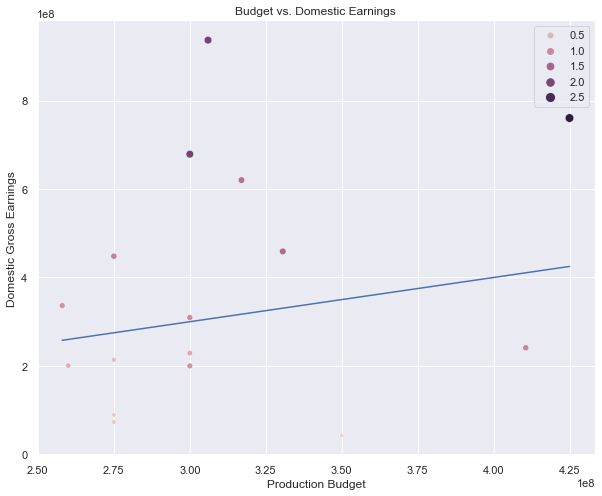

In [33]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TN_movie_budgets
               WHERE (production_budget > 250000000)
               ORDER BY domestic_gross DESC
               LIMIT 250;""") # Generate data via SQL Query
financial_df = dataframe_creator() #Create Dataframe
print(financial_df) #Pulled data for presentation
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    size=financial_df['worldwide_gross'],
    hue=financial_df['worldwide_gross']
    )
# To create line for reference of production budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot)


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

                                           movie  production_budget  \
0           Star Wars Ep. VII: The Force Awakens          306000000   
1                                         Avatar          425000000   
2                                  Black Panther          200000000   
3                         Avengers: Infinity War          300000000   
4                                        Titanic          200000000   
5                                 Jurassic World          215000000   
6                                   The Avengers          225000000   
7              Star Wars Ep. VIII: The Last Jedi          317000000   
8                                  Incredibles 2          200000000   
9                                The Dark Knight          185000000   
10                  Rogue One: A Star Wars Story          200000000   
11                          Beauty and the Beast          160000000   
12                                  Finding Dory          200000000   
13    

[]

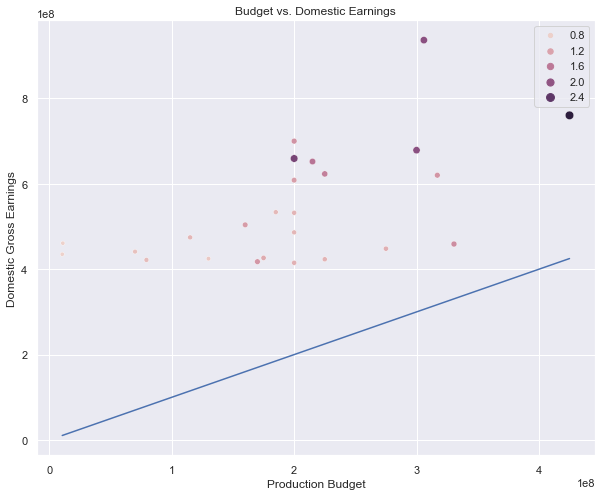

In [34]:
cur.execute("""SELECT movie, 
                      production_budget, 
                      domestic_gross, 
                      worldwide_gross
               from TN_movie_budgets
               ORDER BY domestic_gross DESC
               LIMIT 25;""") # Generate data via SQL Query
financial_df = dataframe_creator() #Create Dataframe
print(financial_df) #Pulled data for presentation
financial_plot = sns.scatterplot(
    x=financial_df['production_budget'],
    y=financial_df['domestic_gross'],
    size=financial_df['worldwide_gross'],
    hue=financial_df['worldwide_gross']
    )
# To create line for reference of production budget
x = np.linspace(min(financial_df['production_budget']),max(financial_df['production_budget']))
y = x
sns.lineplot(x=x, y=y, ax=financial_plot)


financial_plot.set_xlabel("Production Budget")
financial_plot.set_ylabel("Domestic Gross Earnings")
financial_plot.set_title("Budget vs. Domestic Earnings")
financial_plot.plot()

 It is important to detemine what types of content are doing well, in terms of both audience and genre. Filtering by rating and genre should give the results needed to determine the best course of action.

In [60]:
cur.execute("""SELECT rating,
                      genre,
                      box_office
               from RTMovie
               ORDER BY box_office DESC
               LIMIT 500;
               """)
content_df = dataframe_creator()

In [61]:
rough_genre_data = pd.DataFrame()
for item in content_df['genre']:
    if type(item) is str:
        genres = item.split("|")
        for genre in genres:
            genre_temp = pd.DataFrame({'genres':genre},index=[0])
            rough_genre_data = rough_genre_data.append(genre_temp)
    else:
        pass
    
rough_genre_data.groupby(['genres']).head()

rough_genre_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 0 to 0
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genres  1120 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [67]:
cur.execute("""SELECT genres         
               from imdb_basics_df
               WHERE (numvotes > 100000)
               ORDER BY averagerating DESC
               LIMIT 250;
               """)
genres_df2 = dataframe_creator()
genres_df2.head()

,genres
0,"Action,Drama,War"
1,"Action,Adventure,Sci-Fi"
2,"Action,Adventure,Sci-Fi"
3,"Adventure,Drama,Sci-Fi"
4,"Biography,Comedy,Drama"


In [68]:
genres_data = pd.DataFrame()
for item in genres_df2['genres']:
    if type(item) is str:
        genres = item.split(",")
        for genre in genres:
            genre_temp = pd.DataFrame({'genres':genre},index=[0])
            genres_data = genres_data.append(genre_temp)
    else:
        pass
    
genres_data = genres_data.append(rough_genre_data)

# Data Cleaning
genres_data.replace(['Action', 'Adventure'],'Action and Adventure', inplace=True)
genres_data.replace(['Sci-Fi', 'Fantasy'], 'Science Fiction and Fantasy', inplace=True)
genres_data.replace(['Mystery', 'Crime', 'Mystery and Suspense'], 'Mystery, Crime, and Suspense', inplace=True)
genres_data.replace('Sport', 'Sports and Fitness', inplace=True)
genres_data.replace(['Thriller','Horror'], 'Horror and Thriller', inplace=True)
genres_data.replace('Family', 'Kids and Family', inplace=True)
genres_data.replace('War', 'Drama', inplace=True)
genres_data.replace(['Music','Musical'], 'Musical and Performing Arts', inplace=True)
genres_data.replace(['Art House and International','Faith and Spirituality', 'Cult Movies', 'Classics', 'Television'], 'Special Interest', inplace=True)

counts = genres_data['genres'].value_counts()
counts1 = counts.to_dict()
genres_data['counts'] = genres_data['genres'].map(counts1)

genres_data.drop_duplicates(inplace=True)

print(genres_data['genres'].unique())

genres_data

['Action and Adventure' 'Drama' 'Science Fiction and Fantasy' 'Biography'
 'Comedy' 'Musical and Performing Arts' 'Animation' 'Horror and Thriller'
 'Western' 'Mystery, Crime, and Suspense' 'Sports and Fitness' 'History'
 'Romance' 'Kids and Family' 'Documentary' 'Special Interest']


,genres,counts
0,Action and Adventure,284
0,Drama,449
0,Science Fiction and Fantasy,103
0,Biography,39
0,Comedy,258
0,Musical and Performing Arts,43
0,Animation,51
0,Horror and Thriller,102
0,Western,11
0,"Mystery, Crime, and Suspense",159


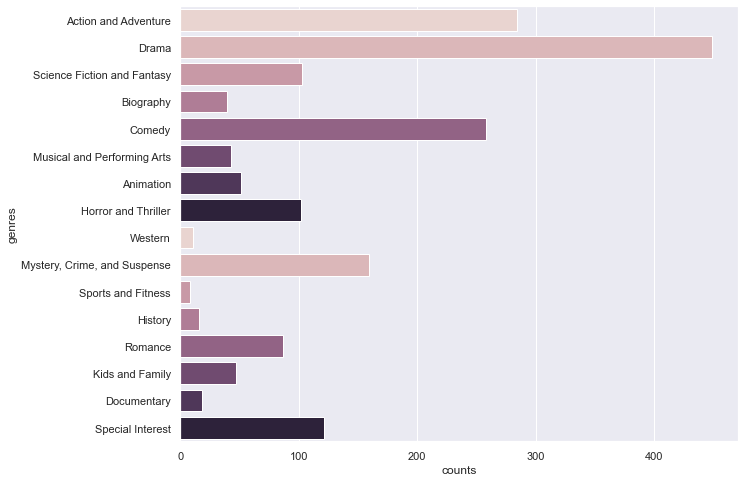

In [69]:
genre_plot = sns.barplot(x=genres_data['counts'], 
                         y=genres_data['genres'], 
                         palette=sns.cubehelix_palette(8)
                        )

This graph helps us see the most popular genres 

In [70]:
ratings_df = pd.DataFrame()
ind = 0
for item in content_df['rating']:
    if type(item) is str:
        rating_temp = pd.DataFrame({'ratings':item, 'count':1},index=[ind])
        ratings_df = ratings_df.append(rating_temp)
        ind +=1
    else:
        pass    

ratings_df = ratings_df.groupby('ratings').count()

  ratings  count
0       G     17
1    NC17      1
2      NR     80
3      PG     73
4   PG-13    129


<AxesSubplot:>

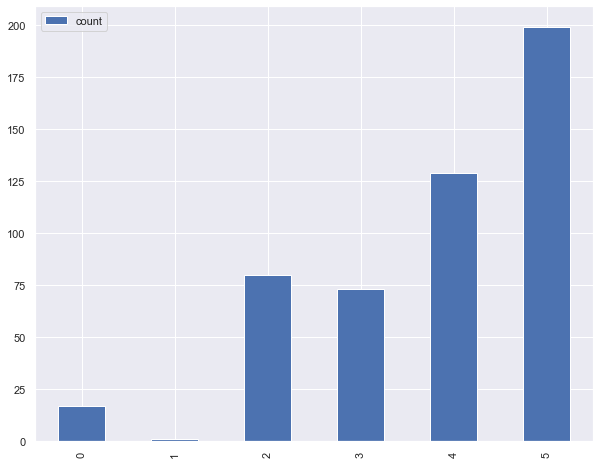

In [71]:
ratings_df = ratings_df.reset_index()
print(ratings_df.head())
ratings_df.plot(kind='bar')

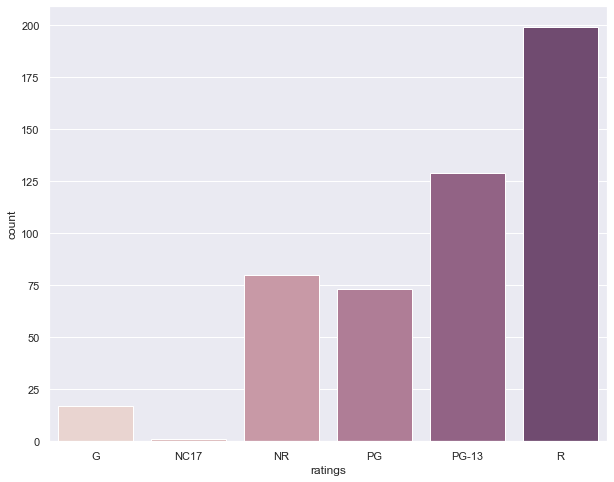

In [72]:
genre_plot = sns.barplot(x=ratings_df['ratings'],
                         y=ratings_df['count'],
                         palette=sns.cubehelix_palette(8))

# Conclusion

Microsoft's move into the movie business would likely result in solid profit margins. Looking at content, genre and rating are likely the most important focuses. Also, the financials of the production must align with the goals of the company and what needs to be gathered from the data is what the general investment would need to be in order to promote positive profit margins.

The recommendations that the data supports are as follows. Based on past trends, it is best to produce action, adventure, drama, and comedy movies, as they tend to do best in the box office. In terms of audience, the most commonly seen ratings in profitable movies are typically PG-13 to R; anything outside of this scope is limited. The final area for recommendation is the financials; the data supports a budget of $250,000,000 or less. This is evidenced by the fact that as we look at the highest-grossing films of the last 25 years, this budget typically gives a solid profit margin both domestically and internationally.